# Grad-CAM to visualise where the CNN is looking
-----

#### Initial Setup
---


In [0]:
## Connecting google drive to colab

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.6-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-w0la5d0m
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-w0la5d0m
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-d2ok3i5t/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [0]:
from classification_models.resnet import ResNet18, preprocess_input
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

### Load CIFAR10 Data
---------


In [0]:
num_classes = 10

# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

X_train = x_train
X_test = x_test
Y_train = y_train
Y_test = y_test

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [0]:
# convert to one hot encoding 
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

### Create Model and Load Weights
----

A pretrained ResNet 18 model on Imagenet data, was trained for 10 epochs on CIFAR 10 data and used for prediction.

In [0]:
# build model
base_model = ResNet18(input_shape=(img_height,img_width,channel), weights='imagenet', include_top=False)
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])

# train
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

W0703 10:20:53.136503 139625901139840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 10:20:53.196716 139625901139840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0703 10:20:53.197894 139625901139840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0703 10:20:53.201000 139625901139840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0703 10:20:53.205374 139625

44924928/44920640 [==============================] - 1s 0us/step


W0703 10:21:00.025837 139625901139840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [0]:
model.fit(X_train, Y_train, epochs=10)

W0703 10:56:47.680121 139625901139840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
50000/50000 [==============================] - 105s 2ms/step - loss: 0.9996 - acc: 0.6564
Epoch 2/10
50000/50000 [==============================] - 100s 2ms/step - loss: 0.6414 - acc: 0.7781
Epoch 3/10
50000/50000 [==============================] - 100s 2ms/step - loss: 0.5014 - acc: 0.8267
Epoch 4/10
50000/50000 [==============================] - 100s 2ms/step - loss: 0.4012 - acc: 0.8591
Epoch 5/10
50000/50000 [==============================] - 100s 2ms/step - loss: 0.3269 - acc: 0.8856
Epoch 6/10
50000/50000 [==============================] - 99s 2ms/step - loss: 0.2586 - acc: 0.9092
Epoch 7/10
50000/50000 [==============================] - 99s 2ms/step - loss: 0.2083 - acc: 0.9270
Epoch 8/10
50000/50000 [==============================] - 99s 2ms/step - loss: 0.1617 - acc: 0.9431
Epoch 9/10
50000/50000 [==============================] - 100s 2ms/step - loss: 0.1324 - acc: 0.9533
Epoch 10/10
50000/50000 [==============================] - 100s 2ms/step - loss: 0.1109 - acc:

In [0]:
# final weights were saved on drive
model.save_weights("drive/GradCam/ResNet18Model.h5")

In [0]:
model.load_weights("drive/GradCam/ResNet18Model.h5")

### Generate Predictions from Test Data
---


In [0]:
predictions = model.predict(X_test)

In [0]:
class_idx = np.argmax(predictions, axis=1) #axis=1 for row wise max
class_idx = np.reshape(class_idx, (len(class_idx),1))

In [0]:
print(f"Number of correct predictions: {np.count_nonzero(class_idx == y_test)}")
print(f"Validation Accuracy: {(np.count_nonzero(class_idx == y_test))/len(class_idx)}")

Number of correct predictions: 8120
Validation Accuracy: 0.812


In [0]:
#Indexes of misclassified output
misclassified_images_index = np.argwhere((y_test == class_idx) == False)[:,0]

Predicted index: 9 - Correct Index: 1


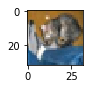

In [0]:
print(f"Predicted index: {class_idx[misclassified_images_index[0]][0]} - Correct Index: {y_test[misclassified_images_index[0]][0]}")
fig, ax = plt.subplots(figsize=(1, 1))
ax.imshow(x_test[0], aspect='auto')

## Analysis of model using GradCam
-----

In [0]:
last_conv_layer = model.get_layer("stage4_unit1_relu1")

### Analysing sample misclassified test data
---



In [0]:
class_output = model.output[:, y_test[0][0]]

In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([np.expand_dims(x_test[0], axis=0)])
for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [0]:
conv_layer_output_value.shape

(2, 2, 256)

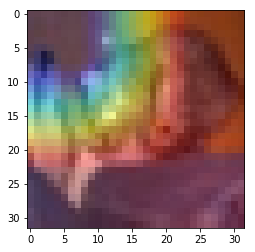

In [0]:
img = x_test[0]
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
plt.imshow(img)
plt.imshow(superimposed_img)

### Using GradCAM to check 50 misclassified images
---------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


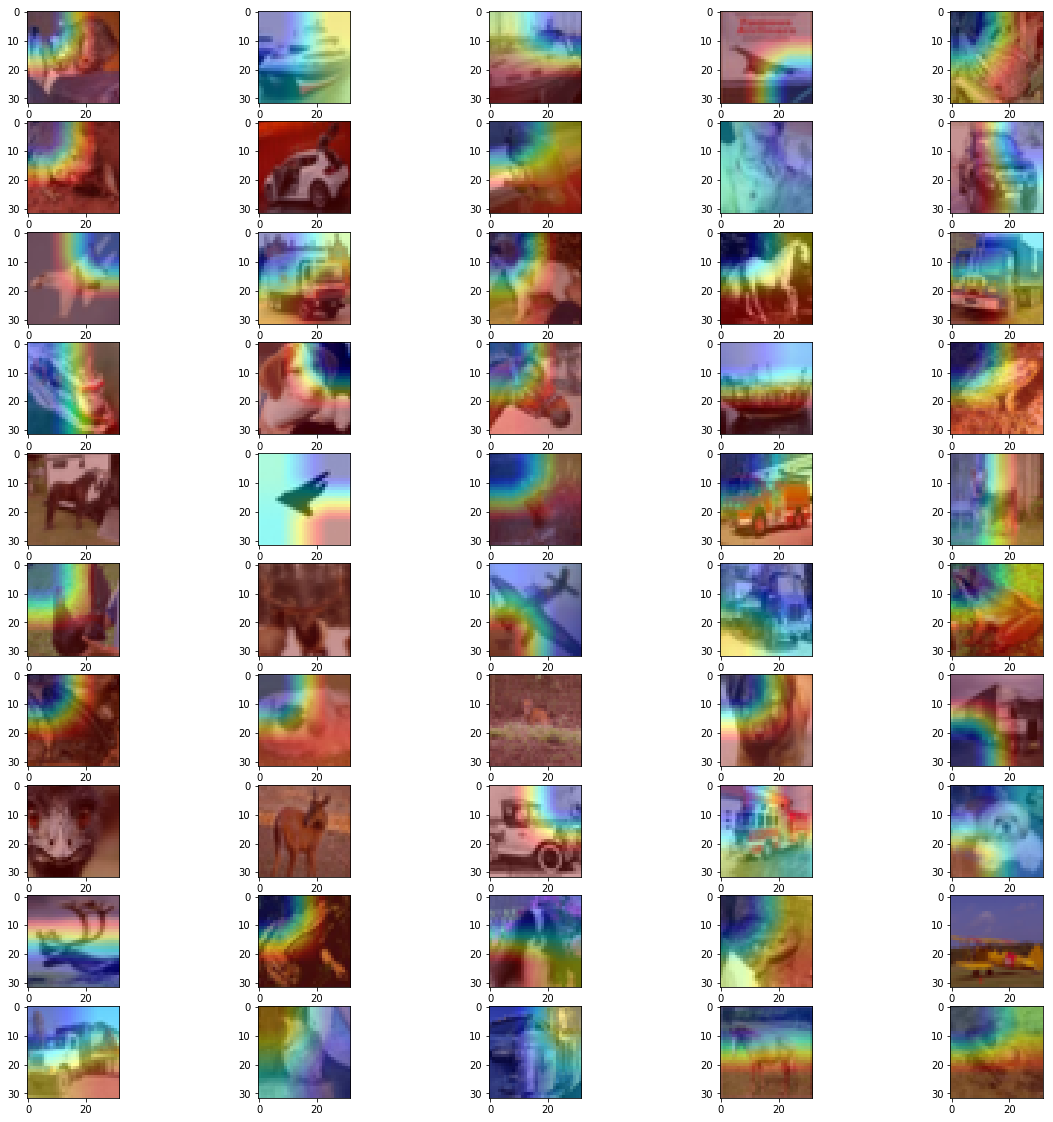

In [0]:
max_misclassified_imgs = 50
last_conv_layer = model.get_layer("stage4_unit1_relu1")

fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 10
ind = 1

for index in range(max_misclassified_imgs):
  class_output = model.output[:, y_test[index][0]]
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([np.expand_dims(x_test[index], axis=0)])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  #print(f"index: {index}")
  #print(conv_layer_output_value)
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  #print(heatmap)
  
  img = x_test[index]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  
  label_str = f"Predicted index: {class_idx[misclassified_images_index[index]][0]} - Correct Index: {y_test[misclassified_images_index[index]][0]}"
  fig.add_subplot(rows, columns, ind, label=label_str)
  
  plt.imshow(img)
  plt.imshow(superimposed_img)
  
  ind = ind + 1

plt.show()